In [0]:
import cv2
import numpy as np
import skimage
from skimage import io, transform
import matplotlib.pyplot as plt
import math

Most of this code utility functions. Scroll down for the actual classification code

In [0]:
def switchBR(img):
  r,g,b = cv2.split(img)
  return cv2.merge((b,g,r))

def switchBRvals(vals):
  return (vals[2], vals[1], vals[0])

In [0]:
def cropToSize(img, imgNewSize):

  startX = (int)(img.shape[0]/2 - imgNewSize[0]/2)
  startY = (int)(img.shape[1]/2 - imgNewSize[1]/2)
  
  return img[startX: (startX + imgNewSize[0]),  startY : (startY + imgNewSize[1])]

def showImg(img, title):
  plt.imshow(img, cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.title(title)
  
def createSolidColorImg(colorComponents, width=16, height=16):
  img = np.zeros((width, height, 3), np.uint8)
  img[:,:] = (colorComponents[0], colorComponents[1], colorComponents[2])
  return img

Threshold values for skin color detection within the image. 
These are used to detect which parts of the image have skin. Also has the threshold values for the white background

In [0]:
# Some HSV thresholds for skin color
lower1 = [0, 40, 0]; upper1 = [25, 255, 255] # Source: https://github.com/Jeanvit/PySkinDetection/blob/master/src/jeanCV.py
lower2 = [0, 50, 0]; upper2 = [120, 150, 255] # Source: https://github.com/WillBrennan/SkinDetector/blob/master/skin_detector/skin_detector.py
lower3 = [0, 48, 80]; upper3 = [20, 255, 255] # source: https://www.pyimagesearch.com/2014/08/18/skin-detection-step-step-example-using-python-opencv/
lower4 = [0, 15, 0]; upper4 = [17, 170, 255] # Source: https://github.com/CHEREF-Mehdi/SkinDetection

#lower4 = [0, 50, 0]; upper4 = [17, 170, 200]

lower_HSV_values = np.array(lower4, dtype = "uint8")
upper_HSV_values = np.array(upper4, dtype = "uint8")

lower_YCrCb_values = np.array([0, 135, 85], dtype="uint8")
upper_YCrCb_values = np.array([255,180,135], dtype="uint8")

lower_HSV_background_values1 = np.array([0, 0, 150], dtype = "uint8")
upper_HSV_background_values1 = np.array([255, 20, 255], dtype = "uint8")

lower_HSV_background_values2 = np.array([0, 0, 200])
upper_HSV_background_values2 = np.array([255, 50, 255])

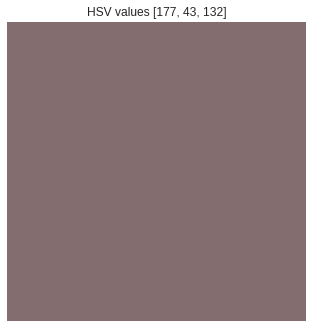

In [5]:
testVals = [177, 43, 132]
showImg(switchBR(cv2.cvtColor(createSolidColorImg(testVals), cv2.COLOR_HSV2BGR)), "HSV values " + str(testVals))
plt.show()

The next cell has the code for performing classifications from raw colors

In [0]:
def classifySkintypeITA(ita):
  if (ita < -30):
    return 6
  elif -30 <= ita < 10:
    return 5
  elif 10 <= ita < 28:
    return 4
  elif 28 <= ita < 41:
    return 3
  elif 41 <= ita < 55:
    return 2
  elif 55 <= ita:
    return 1

def RGBtoLABvals(RGBvals):
  img = createSolidColorImg(RGBvals)
  labVals = cv2.cvtColor(switchBR(img), cv2.COLOR_BGR2LAB)[0,0]
  return labVals

def convertColorspaceVals(vals, cvConstant):
  img = createSolidColorImg(vals)
  convertedVals = cv2.cvtColor(img, cvConstant)[0,0]
  return convertedVals

def normalizeLabVals(labVals, roundVals = False):
  L, a, b = labVals
  L = L*100.0/255
  a = (a - 128)*100.0/128
  b = (b - 128)*100.0/128
  
  if (roundVals):
    L, a, b = round(L), round(a), round(b)
    
  return (L, a, b)

def calcITA(vals, RGBnotLAB = False, normalizedLAB = True):
  labVals = None
  if (RGBnotLAB):
    labVals = normalizeLabVals(RGBtoLABvals(vals))
  else:
    if normalizedLAB:
      labVals = vals
    else:
      labVals = normalizeLabVals(vals)
  return math.degrees(math.atan2(labVals[0] - 50, labVals[2]))
  
def classifySkintypeLAB(labVals):
  ita = calcITA(labVals)
  return classifySkintypeITA(ita)

def classifySkintypeRGB(RGBvals):
  ita = calcITA(RGBvals, RGBnotLAB = True)
  return classifySkintypeITA(ita)

The next cell contains the classification algorithm from https://github.com/terrybu/How-Much-Sunlight-Do-You-Need

I found it not very good

In [0]:
terryBuSkinTypeColors = [(245, 226, 222), (243, 208, 178), (231, 181, 144), (200, 119, 82), (165, 91, 44), (61, 31, 29)]

def terryBuClassify(colorRGB):
  disparityScoreList = []
  for typeColor in terryBuSkinTypeColors:
    disparityScore = abs(colorRGB[0] - typeColor[0]) + abs(colorRGB[1] - typeColor[1]) + abs(colorRGB[2] - typeColor[2])
    disparityScoreList.append(disparityScore)
  
  return disparityScoreList.index(min(disparityScoreList)) + 1

Contrast stretch was not used in final skin color classification algorithm

In [0]:
def contrastStretch(bwImage):
  floatImage = np.float64(bwImage)
  min_im = np.min(np.min(floatImage))
  max_im = np.max(np.max(floatImage))
  return np.uint8(255*(floatImage-min_im)/(max_im-min_im))

In [0]:
def classifyAndShowColor(colorBGR, title):
  colorLAB = convertColorspaceVals(colorBGR, cv2.COLOR_BGR2LAB)
  ita = calcITA(colorLAB, normalizedLAB = False)
  colorHSV = convertColorspaceVals(colorBGR, cv2.COLOR_BGR2HSV)
  colorRGB = switchBRvals(colorBGR)
  showImg(createSolidColorImg(colorRGB), title + "\nRGB " + str(colorRGB) + "\nHSV " + str(colorHSV) +"\nLAB" + str(colorLAB) + "\nITA " + str(round(ita, 2)) + "\nClassified type " + str(classifySkintypeITA(ita)) + "\n Classified type TerryBu " + str(terryBuClassify(colorRGB)))

The code in the next cell doesn't work and will probably not be needed

In [0]:
# This function doesn't work and will probably not be needed
def classifyDominantColorsMask(img, skinMask):
  Z = img[skinMask, :].reshape((-1, 3))
  print(Z.shape)
  print(Z)
  
  Z = np.float32(Z)
  
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 3
  ret,labels,centers=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
  
  centers = np.uint8(centers)
  print (len(centers))
  for i in range(len(centers)):
    plt.subplot(1, len(labels), i)
    classifyAndShowColor(centers[i])

In [0]:
def adjustColorToBackgroundLighting(colorBGR, meanBackgroundColorHSV):
  
  meanColorHSV = convertColorspaceVals(colorBGR, cv2.COLOR_BGR2HSV)
  
  #adjustedValue =  meanColorHSV[2] + 255 - meanBackgroundColorHSV[2]
  #adjustedValue = round(meanColorHSV[2]*(1 + 2*(255-meanBackgroundColorHSV[2])/255.0))
  adjustedValue = 255*(meanColorHSV[2]/meanBackgroundColorHSV[2])
  adjustedValue = np.clip(adjustedValue, 0, 255)
  adjustedMeanColorHSV = (meanColorHSV[0], meanColorHSV[1], adjustedValue)
  adjustedMeanColor = convertColorspaceVals(adjustedMeanColorHSV, cv2.COLOR_HSV2BGR)
  return adjustedMeanColor

In [0]:
#Test files
fileNames = ["Meir.jpg",  "Dana.jpeg", "Elwin.jpeg", "Gal.jpeg", "Guy.jpeg", "LeenaLibrary.jpg", "Natalia home.jpg", "Ziv.jpeg", "DarkSkinnedPerson.jpg"]

The next cell contains the actual skin color classification code

In [0]:

def classifySkinTypeFromImg(img):
  
  # K-means quantization
  Z = img.reshape((-1,3))
  Z = np.float32(Z)
  
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 5
  ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
  
  center = np.uint8(center)
  res = center[label.flatten()]
  res2 = res.reshape((img.shape))
  
  # Colorspaces
  img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
  
  img = res2
  
  # Colorspaces
  img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
  
  # Masking
  mask_hsv = cv2.inRange(img_hsv, lower_HSV_values, upper_HSV_values)
  mask_hsv = cv2.morphologyEx(mask_hsv, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
  
  YCrCb_mask = cv2.inRange(img_YCrCb, lower_YCrCb_values, upper_YCrCb_values)
  YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
  
  
  skinMask = cv2.bitwise_and(YCrCb_mask, mask_hsv)
  skinMask = cv2.morphologyEx(skinMask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
  skinMask = cv2.medianBlur(skinMask, 3)
  
  backgroundMask1 = cv2.inRange(img_hsv, lower_HSV_background_values1, upper_HSV_background_values1)
  backgroundMask1 = cv2.morphologyEx(backgroundMask1, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
  backgroundMask2 = cv2.inRange(img_hsv, lower_HSV_background_values2, upper_HSV_background_values2)
  backgroundMask2 = cv2.morphologyEx(backgroundMask2, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
  
  backgroundMask = cv2.bitwise_or(backgroundMask1, backgroundMask2)
  backgroundMask = cv2.medianBlur(backgroundMask, 3)
  
  skinMask = cv2.bitwise_and(skinMask, cv2.bitwise_not(backgroundMask))
  
  # Color classification calculations
  meanColor = cv2.mean(img, skinMask)
  meanBackgroundColor = cv2.mean(img, backgroundMask)
  
  #Probably should have used switchBRvals here but I don't want to change this now
  meanColorRGB = (round(meanColor[2], 1), round(meanColor[1], 1), round(meanColor[0], 1)) 
  meanBackgroundColorRGB = (round(meanBackgroundColor[2], 1), round(meanBackgroundColor[1], 1), round(meanBackgroundColor[0], 1))

  meanColorHSV = convertColorspaceVals(meanColor, cv2.COLOR_BGR2HSV)
  meanBackgroundColorHSV = convertColorspaceVals(meanBackgroundColor, cv2.COLOR_BGR2HSV)
  
  adjustedMeanColor = adjustColorToBackgroundLighting(meanColor, meanBackgroundColorHSV)
  skintype = classifySkintypeRGB(switchBRvals(adjustedMeanColor))
  
  return skintype, adjustedMeanColor



In [14]:
img = cv2.imread("Elwin.jpeg")
skintype, color = classifySkinTypeFromImg(img)
print(skintype)
print(type(skintype))

3
<class 'int'>


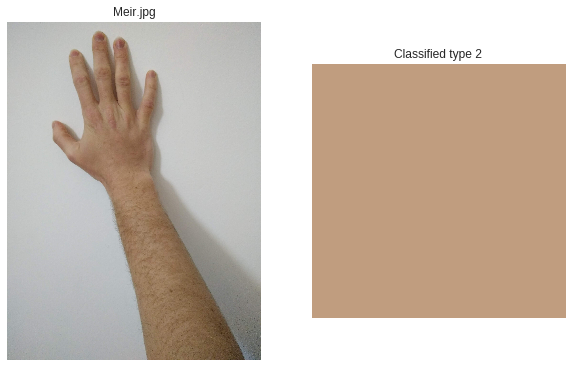

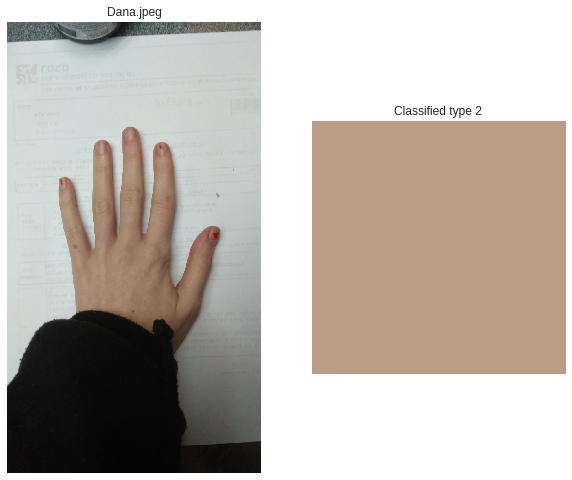

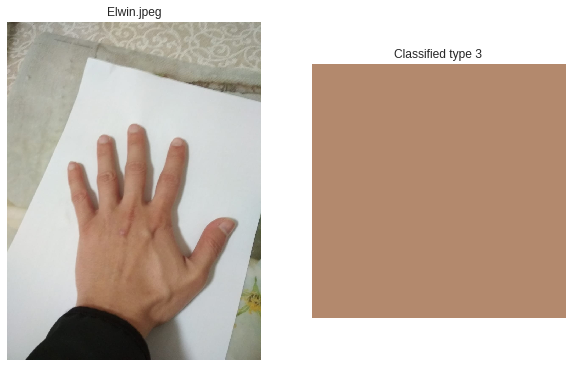

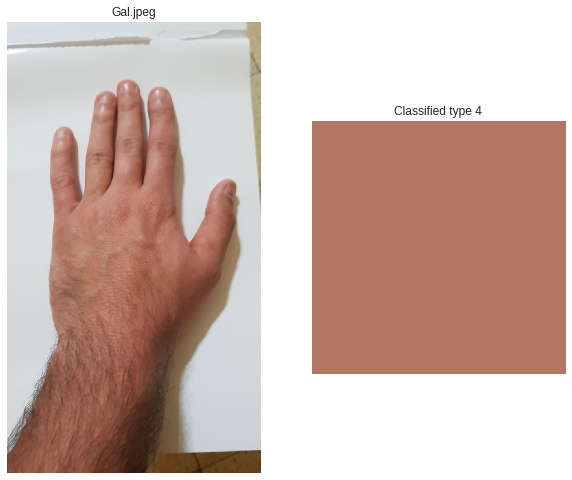

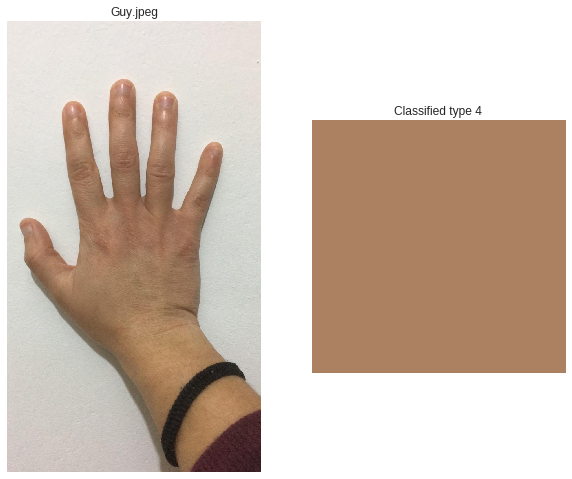

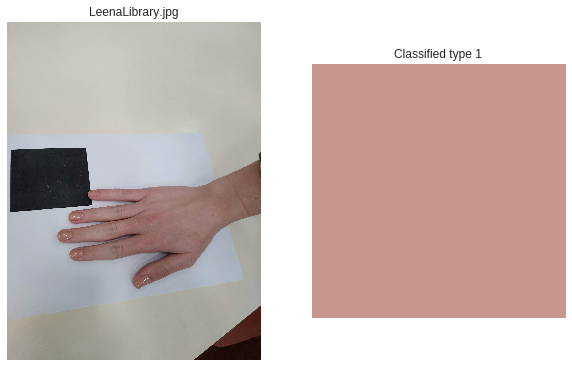

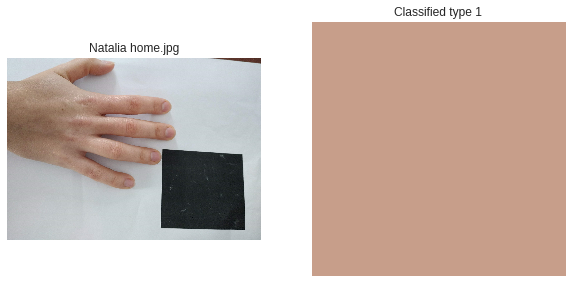

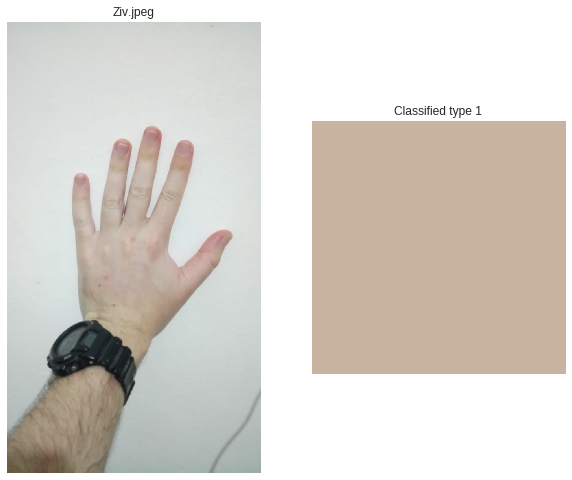

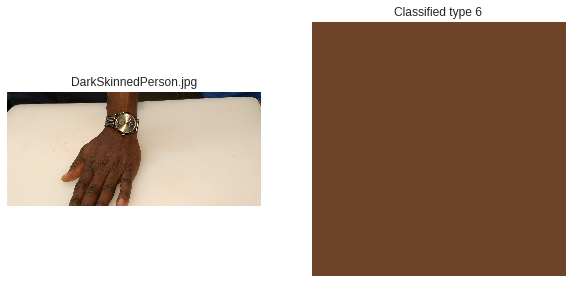

In [15]:
for imageFile in fileNames:
  img = cv2.imread(imageFile)
  assert type(img) is not type(None), "Could not open file " + imageFile
  
  skintype, color = classifySkinTypeFromImg(img)
  plt.figure(figsize = (10, 10))
  plt.subplot(1, 2, 1)
  showImg(switchBR(img), imageFile)
  plt.subplot(1,2,2)
  showImg(switchBR(createSolidColorImg(color)), "Classified type " + str(skintype))
  plt.show()

The next cell is used to develop and test the algorithm,  exposing the intermediate steps for debugging.

In [16]:

#fileNames = ["Meir.jpg", "Dana.jpeg", "Elwin.jpeg", "Gal.jpeg", "Guy.jpeg", "LeenaLibrary.jpg", "Natalia home.jpg", "Ziv.jpeg", "DarkSkinnedPerson.jpg"]

#fileNames = ["Guy.jpeg"]

for imageFile in fileNames:
  #print(imageFile)
  img = cv2.imread(imageFile)
  
  assert type(img) is not type(None), "Could not open file " + imageFile
  
  #Resize was just to preserve memory because the runtime kept crashing
  img = cv2.resize(img, ((int)(800*img.shape[1]/img.shape[0]), 800)) 
  
  #showImg(switchBR(img), imageFile)
  plt.imshow(switchBR(img))
  plt.title(imageFile)
  plt.show()
  
  print(img.shape)
  
  # K-means quantization
  Z = img.reshape((-1,3))
  Z = np.float32(Z)
  
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 5
  ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
  
  center = np.uint8(center)
  res = center[label.flatten()]
  res2 = res.reshape((img.shape))
  
  plt.figure(figsize=(10,10))
  showImg(switchBR(res2), "Quantized to " + str(K) + " colors")
  plt.show()
  
  img = res2
  
  # Colorspaces
  img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
  
  # Contrast stretch
  h, s, v = cv2.split(img_hsv)
  contrastStretchedValues = contrastStretch(v)

  minimumValue = np.min(v)
  maximumValue = np.max(v)

  print("Minimum value " + str(minimumValue))
  print("Maximum value " + str(maximumValue))

  contrastStretchedImgHSV = cv2.merge((h, s, contrastStretchedValues))

  showImg(switchBR(cv2.cvtColor(contrastStretchedImgHSV, cv2.COLOR_HSV2BGR)), "Contrast Stretched")
  plt.show()
  
  
  
  
  # Masking
  mask_hsv = cv2.inRange(img_hsv, lower_HSV_values, upper_HSV_values)
  mask_hsv = cv2.morphologyEx(mask_hsv, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
  
  YCrCb_mask = cv2.inRange(img_YCrCb, lower_YCrCb_values, upper_YCrCb_values)
  YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
  
  
  skinMask = cv2.bitwise_and(YCrCb_mask, mask_hsv)
  skinMask = cv2.morphologyEx(skinMask, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
  skinMask = cv2.medianBlur(skinMask, 3)
  
  backgroundMask1 = cv2.inRange(img_hsv, lower_HSV_background_values1, upper_HSV_background_values1)
  backgroundMask1 = cv2.morphologyEx(backgroundMask1, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
  backgroundMask2 = cv2.inRange(img_hsv, lower_HSV_background_values2, upper_HSV_background_values2)
  backgroundMask2 = cv2.morphologyEx(backgroundMask2, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
  backgroundMask = cv2.bitwise_or(backgroundMask1, backgroundMask2)
  backgroundMask = cv2.medianBlur(backgroundMask, 3)
  
  skinMask = cv2.bitwise_and(skinMask, cv2.bitwise_not(backgroundMask))
  
  middleIndex = ((int)(img.shape[0]/2), (int)(img.shape[1]/2))
  selectedIndex = middleIndex
  
  
  # Display mask results
  print(skinMask.shape)
  print("Selected pixel index: " + str(selectedIndex))
  print("Skin ask selected pixel: " + str(skinMask[selectedIndex]))
  print("HSV selected pixel: " + str(img_hsv[selectedIndex]))
  print("img selected pixel: " + str(img[selectedIndex]))

  plt.figure(figsize=(20, 10))
  plt.subplot(1, 4, 1)
  plt.imshow(skinMask, cmap="gray")
  plt.title("The skin mask")

  plt.subplot(1, 4, 2)
  plt.imshow(backgroundMask, cmap="gray")
  plt.title("The background mask")

  skin = cv2.bitwise_and(img, img, mask = skinMask)
  background = cv2.bitwise_and(img, img, mask = backgroundMask)

  skinRGB = switchBR(skin)

  plt.subplot(1, 4, 3)
  showImg(skinRGB, "Masked skin")

  plt.subplot(1, 4, 4)

  showImg(switchBR(background), "Masked background")
  plt.show()

  #img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

  #meanColorLAB = cv2.mean(img_lab, skinMask)

  # Color classification calculations
  meanColor = cv2.mean(img, skinMask)
  meanBackgroundColor = cv2.mean(img, backgroundMask)
  meanColorRGB = (round(meanColor[2], 1), round(meanColor[1], 1), round(meanColor[0], 1)) #SwitchBR
  meanBackgroundColorRGB = (round(meanBackgroundColor[2], 1), round(meanBackgroundColor[1], 1), round(meanBackgroundColor[0], 1)) #SwitchBR

  meanColorHSV = convertColorspaceVals(meanColor, cv2.COLOR_BGR2HSV)
  meanBackgroundColorHSV = convertColorspaceVals(meanBackgroundColor, cv2.COLOR_BGR2HSV)

  #print ("Mean color converted to LAB " + str(convertColorspaceVals(meanColor, cv2.COLOR_BGR2LAB)))
  #print("Mean color of LAB image" + str(meanColorLAB))

  meanColorContrastStretched = cv2.mean(contrastStretchedImgHSV, skinMask)
  

  selectedPixel = img[selectedIndex]
  selectedPixelHSV = img_hsv[selectedIndex]
  #meanColor = np.mean(skinRGB, axis=(0,1))
  
  
  # Display color results
  plt.figure(figsize=(20, 10))
  plt.subplot(1,5,1)
  classifyAndShowColor(meanColor, "Mean color")

  plt.subplot(1,5,2)
  showImg(createSolidColorImg(meanBackgroundColorRGB), "Mean background color" + "\nHSV " + str(meanBackgroundColorHSV))


  
  adjustedMeanColor = adjustColorToBackgroundLighting(meanColor, meanBackgroundColorHSV)
  
  adjustedValueSelectedPixel = 255*(selectedPixelHSV[2]/meanBackgroundColorHSV[2])
  adjustedSelectedPixelHSV = (selectedPixelHSV[0], selectedPixelHSV[1], adjustedValueSelectedPixel)
  adjustedSelectedPixel = convertColorspaceVals(adjustedSelectedPixelHSV, cv2.COLOR_HSV2BGR)
  
  plt.subplot(1,5,3)
  classifyAndShowColor(adjustedMeanColor, "Adjusted mean color")

  plt.subplot(1,5,4)
  classifyAndShowColor(selectedPixel, "Selected pixel " + str(selectedIndex))
  
  plt.subplot(1,5,5)
  classifyAndShowColor(adjustedSelectedPixel, "Adjusted selected pixel")
  
  
  
  plt.figure(figsize=(20, 10))
  for i in range(len(center)):
    plt.subplot(1, len(center), i+1)
    classifyAndShowColor(center[i], "Dominant Color " + str(i))
    
  plt.show()

  plt.figure(figsize=(20, 10))
  for i in range(len(center)):
    plt.subplot(1, len(center), i+1)
    classifyAndShowColor(adjustColorToBackgroundLighting(center[i], meanBackgroundColorHSV), "Adjusted Dominant Color " + str(i))
  
  plt.show()

  
  

Output hidden; open in https://colab.research.google.com to view.

In [0]:
def plotSquares(rowRange, colRange, constantValue, paramsToHSV):
  for i in range(len(rowRange)):
    plt.figure(figsize=(20,5))
    for j in range(len(colRange)):
      plt.subplot(1, len(colRange), j+1)
      #img = np.array([(rowRange[i], colRange[j], constantValue)], dtype="uint8")
      #img = transform.resize(img, (16, 16), order=0)
      
      img = np.zeros((16,16,3), np.uint8)
      params = (rowRange[i], colRange[j], constantValue)
      img[:,:] = (params[paramsToHSV[0]], params[paramsToHSV[1]], params[paramsToHSV[2]])
      labVals = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_HSV2BGR), cv2.COLOR_BGR2LAB)[0,0]
      ita = calcITA(labVals, normalizedLAB = False)
      
      #showImg(img, "")
      showImg(switchBR(cv2.cvtColor(img, cv2.COLOR_HSV2BGR)), "(" + str(round(params[paramsToHSV[0]], 1)) + ", " + str(round(params[paramsToHSV[1]], 1)) + ", " + str(round(params[paramsToHSV[2]])) + ")"\
             +"\n LAB " + str(labVals) + "\n ITA " + str(round(ita,1)) + "\n type " + str(classifySkintypeITA(ita)))
    plt.show();
    

In [18]:

hueRange = np.linspace(lower_HSV_values[0], upper_HSV_values[0], 10)
satRange = np.linspace(lower_HSV_values[1], upper_HSV_values[1], 10)
valueRange = np.linspace(lower_HSV_values[2], upper_HSV_values[2], 10)


for hue in hueRange:
  print("Hue = " + str(round(hue)))
  plotSquares(satRange, valueRange, hue, (2, 0, 1))

Output hidden; open in https://colab.research.google.com to view.

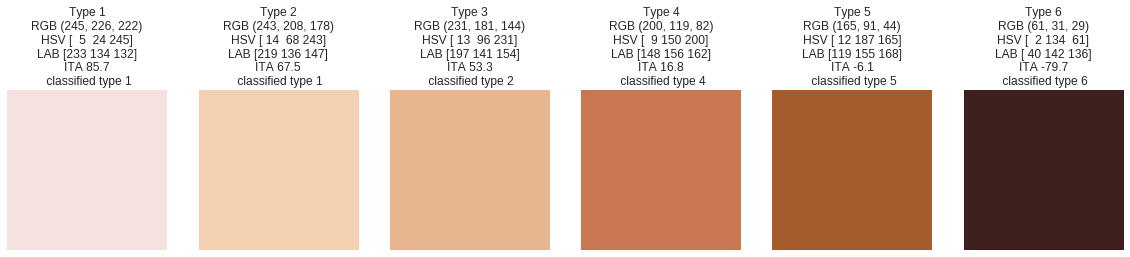

In [19]:
skinTypeColorsRGB = terryBuSkinTypeColors

plt.figure(figsize=(20,5))
for i in range(len(skinTypeColorsRGB)):
  plt.subplot(1, len(skinTypeColorsRGB), i+1)
  img = createSolidColorImg(skinTypeColorsRGB[i])
  hsvVals = cv2.cvtColor(switchBR(img), cv2.COLOR_BGR2HSV)[0, 0]
  
  labVals = RGBtoLABvals(skinTypeColorsRGB[i])
  ita = calcITA(labVals, normalizedLAB = False)
  classifiedType = classifySkintypeITA(ita)
  
  showImg(img, "Type " + str(i + 1) + "\nRGB " + str(skinTypeColorsRGB[i]) + "\nHSV " + str(hsvVals)\
          + "\nLAB " + str(labVals) + "\nITA " + str(round(ita, 1)) + "\n classified type " + str(classifiedType))
plt.show()

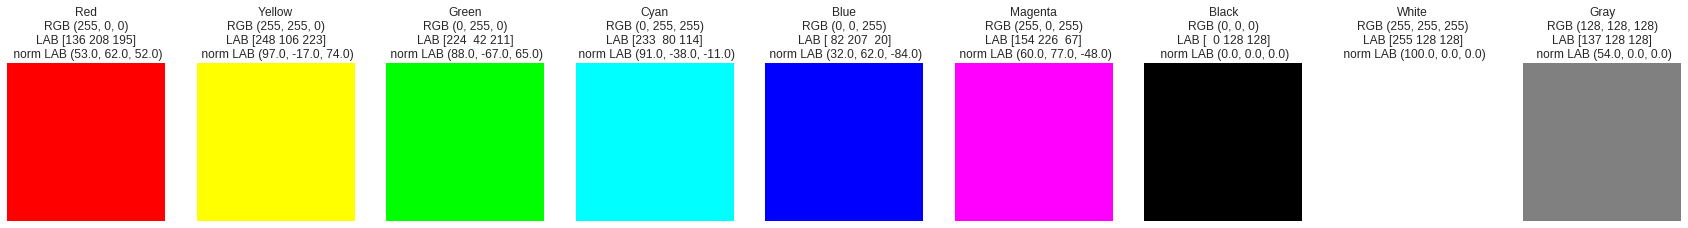

In [20]:
colorsRGB = [(255, 0 , 0), (255, 255, 0), (0, 255, 0), (0, 255, 255), (0, 0, 255), (255, 0, 255), (0, 0, 0), (255, 255, 255), (128, 128, 128)]
colorNames = ['Red', 'Yellow', 'Green', 'Cyan', 'Blue', 'Magenta', "Black", 'White', 'Gray'] 

plt.figure(figsize=(30,5))

for i in range(len(colorsRGB)):
  plt.subplot(1, len(colorsRGB), i+1)
  img = createSolidColorImg(colorsRGB[i])
  labVals = RGBtoLABvals(colorsRGB[i])
  showImg(img, colorNames[i] + "\nRGB " + str(colorsRGB[i]) + "\nLAB " + str(labVals) + '\n norm LAB ' + str(normalizeLabVals(labVals, roundVals=True)))

plt.show()